In [1]:
from keras.models import load_model
import tensorflow as tf
from tensorflow.keras.utils import load_img, img_to_array, array_to_img
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg19 import preprocess_input, decode_predictions
import matplotlib.pyplot as plt

import numpy as np
from IPython.display import Image, display
import matplotlib.cm as cm

#http://gradcam.cloudcv.org/
#https://keras.io/examples/vision/grad_cam/

In [2]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array

In [3]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    
    return heatmap.numpy()

### Variables

In [4]:
# Leemos el modelo guardado
target_size = (224, 224)
path_image = '../../dataset/classification/PCB_Dataset_Split/test/ig/'
name_image = 'MMY_790179.jpg'

model = load_model('../../model/classification/vgg19_trainable_true_best_model.h5')
last_conv_layer_name = "block5_conv4"
decode_predictions = decode_predictions

### Carga y ploteo de la imagen de entrada

(-0.5, 223.5, 223.5, -0.5)

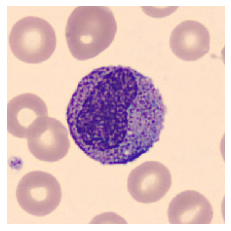

In [5]:
#load the image
my_image = load_img(path_image+name_image, target_size = (224, 224))
plt.imshow(my_image)
plt.axis('off')

### Gradcam

1/1 [==============================] - 5s 5s/step
Predicted: [[ 105.83373 1942.6595  -684.7925  -260.58884 -655.6293  -212.28801
   665.1183  -965.6527 ]]


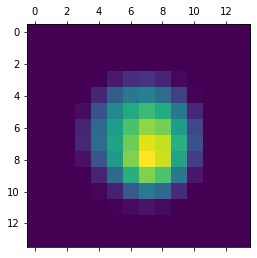

In [6]:
# Prepare image
img_array = preprocess_input(get_img_array(path_image+name_image, size = target_size))

# Make model
#model = model_builder(weights="imagenet")

# Remove last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is
preds = model.predict(img_array)
print("Predicted:", preds)

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

### Utilización de la salida de gradcam

In [8]:
def save_and_display_gradcam(img_path, heatmap, cam_path = "../../images/XAI/"+name_image, alpha = 0.4):
    # Load the original image
    img = load_img(img_path)
    img = img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    print(jet_heatmap.shape)

    # Create an image with RGB colorized heatmap
    jet_heatmap = array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = img_to_array(jet_heatmap)
    
    #rint(jet_heatmap)
    print(jet_heatmap.shape)
    print(img.shape)
    
    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))

(14, 14, 3)
(363, 360, 3)
(363, 360, 3)


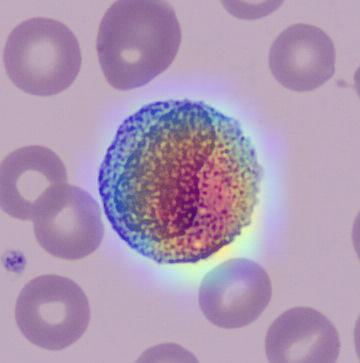

In [9]:
save_and_display_gradcam(path_image+name_image, heatmap)

### Estudio del modelo

In [27]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [4]:
layer_names = [layer.name for layer in model.layers]
layer_names

['input_1',
 'block1_conv1',
 'block1_conv2',
 'block1_pool',
 'block2_conv1',
 'block2_conv2',
 'block2_pool',
 'block3_conv1',
 'block3_conv2',
 'block3_conv3',
 'block3_conv4',
 'block3_pool',
 'block4_conv1',
 'block4_conv2',
 'block4_conv3',
 'block4_conv4',
 'block4_pool',
 'block5_conv1',
 'block5_conv2',
 'block5_conv3',
 'block5_conv4',
 'block5_pool',
 'flatten',
 'dense']

In [5]:
model.layers

In [6]:
layer_outputs = [layer.output for layer in model.layers]
layer_outputs

[<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'input_1')>,
 <KerasTensor: shape=(None, 224, 224, 64) dtype=float32 (created by layer 'block1_conv1')>,
 <KerasTensor: shape=(None, 224, 224, 64) dtype=float32 (created by layer 'block1_conv2')>,
 <KerasTensor: shape=(None, 112, 112, 64) dtype=float32 (created by layer 'block1_pool')>,
 <KerasTensor: shape=(None, 112, 112, 128) dtype=float32 (created by layer 'block2_conv1')>,
 <KerasTensor: shape=(None, 112, 112, 128) dtype=float32 (created by layer 'block2_conv2')>,
 <KerasTensor: shape=(None, 56, 56, 128) dtype=float32 (created by layer 'block2_pool')>,
 <KerasTensor: shape=(None, 56, 56, 256) dtype=float32 (created by layer 'block3_conv1')>,
 <KerasTensor: shape=(None, 56, 56, 256) dtype=float32 (created by layer 'block3_conv2')>,
 <KerasTensor: shape=(None, 56, 56, 256) dtype=float32 (created by layer 'block3_conv3')>,
 <KerasTensor: shape=(None, 56, 56, 256) dtype=float32 (created by layer 'block3_conv4')>,

In [7]:
# Feature Map
feature_map_model = tf.keras.models.Model(inputs = model.input, outputs = layer_outputs)
feature_map_model

In [8]:
feature_maps = feature_map_model.predict(my_image)

1/1 [==============================] - 0s 212ms/step


In [9]:
for layer_name, feature_map in zip(layer_names, feature_maps):
    print(f"The shape of the {layer_name} is =======>> {feature_map.shape}")

The shape of the input_1 is =======>> (1, 224, 224, 3)
The shape of the block1_conv1 is =======>> (1, 224, 224, 64)
The shape of the block1_conv2 is =======>> (1, 224, 224, 64)
The shape of the block1_pool is =======>> (1, 112, 112, 64)
The shape of the block2_conv1 is =======>> (1, 112, 112, 128)
The shape of the block2_conv2 is =======>> (1, 112, 112, 128)
The shape of the block2_pool is =======>> (1, 56, 56, 128)
The shape of the block3_conv1 is =======>> (1, 56, 56, 256)
The shape of the block3_conv2 is =======>> (1, 56, 56, 256)
The shape of the block3_conv3 is =======>> (1, 56, 56, 256)
The shape of the block3_conv4 is =======>> (1, 56, 56, 256)
The shape of the block3_pool is =======>> (1, 28, 28, 256)
The shape of the block4_conv1 is =======>> (1, 28, 28, 512)
The shape of the block4_conv2 is =======>> (1, 28, 28, 512)
The shape of the block4_conv3 is =======>> (1, 28, 28, 512)
The shape of the block4_conv4 is =======>> (1, 28, 28, 512)
The shape of the block4_pool is =======>>